In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**LOADING LIBRARIES**

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import pickle
import matplotlib.pyplot as plt

**LOADING DATA**

In [3]:
with open('./drive/My Drive/RosettaCodeData.csv', errors='ignore') as f:
  data = pd.read_csv(f)

In [4]:
data

,language,code
0,C,#ifndef _CSEQUENCE_H br #define _CSEQUENCE_H b...
1,C,"#include ""csequence.h"" br br static double..."
2,C,#ifndef _WRITETIMINGS_H br #define _WRITETIMIN...
3,C,#include <stdio.h> br #include <stdlib.h> br ...
4,C,#include <stdio.h> br #include <stdlib.h> br #...
...,...,...
29225,Ruby,/* query-rb.c */ br #include <stdlib.h> br #in...
29226,Ruby,# Rakefile br br # To build and run: br # ...
29227,Scala,/* Query.scala */ br object Query { br de...
29228,Scala,/* query-jni.c */ br #include <stdio.h> br #in...


**PREPROCESSING**

In [5]:
#drop rows with missing values
data = data.dropna()

In [6]:
data['language'].value_counts(normalize=True)

Python         0.073676
Haskell        0.059352
Perl           0.053046
Go             0.049825
C              0.048557
Ruby           0.046810
Java           0.045610
JavaScript     0.045268
Julia          0.044342
C++            0.041909
Racket         0.040367
Ada            0.040127
C#             0.038654
Scala          0.036975
Kotlin         0.035433
Fortran        0.029881
PowerShell     0.029676
Rust           0.028408
Groovy         0.026557
R              0.025290
Mathematica    0.022959
Swift          0.021383
PureBasic      0.021315
AWK            0.020184
UNIX Shell     0.019258
PHP            0.019224
COBOL          0.013296
VBA            0.012542
MATLAB         0.008396
SQL PL         0.001679
Name: language, dtype: float64

In [7]:
def preprocess(text):
    """
    Function to preprocess a row of text in dataframe

    Parameters
    ----------
    text: str
      a row of text to preprocess

    Returns
    -------
    text: str
      a row of preprocessed text
    """
    #cast row as string
    text = str(text)
    #replace complex string for comma (complex string was used to avoid csv interpretting commas as new line)
    text = text.replace('!@#$%^&&^%$#@!', ',')
    text = text.replace(' br ', '')
    text = text.replace(' ', '')
    # text = text.replace('<br>', ' ')
    #remove any characters that are non-english, not a number or not a puncutation mark or not a space
    text = ''.join([t for t in text if t in string.printable or t in string.punctuation])
    return text

In [8]:
#apply preprocessing to dataframe
data['code_clean'] = data['code'].apply(preprocess)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
data['code_clean']

0        #ifndef_CSEQUENCE_H#define_CSEQUENCE_H#include...
1        #include"csequence.h"staticdoublefill_constant...
2        #ifndef_WRITETIMINGS_H#define_WRITETIMINGS_H#i...
3        #include<stdio.h>#include<stdlib.h>#include"wr...
4        #include<stdio.h>#include<stdlib.h>#include<ma...
                               ...                        
29225    /*query-rb.c*/#include<stdlib.h>#include<ruby....
29226    #Rakefile#Tobuildandrun:#$rake#$./callruby#Mus...
29227    /*Query.scala*/objectQuery{defcall(data:Array[...
29228    /*query-jni.c*/#include<stdio.h>#include<stdli...
29229    #Makefile#EdittheselinestomatchyourJDK.JAVA_HO...
Name: code_clean, Length: 29182, dtype: object

In [10]:
data['language'].value_counts()

Python         2150
Haskell        1732
Perl           1548
Go             1454
C              1417
Ruby           1366
Java           1331
JavaScript     1321
Julia          1294
C++            1223
Racket         1178
Ada            1171
C#             1128
Scala          1079
Kotlin         1034
Fortran         872
PowerShell      866
Rust            829
Groovy          775
R               738
Mathematica     670
Swift           624
PureBasic       622
AWK             589
UNIX Shell      562
PHP             561
COBOL           388
VBA             366
MATLAB          245
SQL PL           49
Name: language, dtype: int64

In [11]:
#label encoding the target variable
encoder = LabelEncoder()
data['language'] = encoder.fit_transform(data['language'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
#saving the encoder as a pickle file
with open("./drive/My Drive/encoder.p", "wb") as f:
  pickle.dump(encoder, f)

In [13]:
#transforming dependent and independent variable to arrays
X = data['code_clean'].values
y = data['language'].values

In [14]:
#one-hot-encoding target variable
y = to_categorical(y)

In [15]:
#creating training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

In [16]:
#initializing character-level tokenizer
tokenizer = text.Tokenizer(char_level=True, filters=None, lower=False, oov_token='OOV')

In [17]:
#fitting tokenizer on training data
tokenizer.fit_on_texts(X_train)

In [18]:
#saving tokenizer as pickle file
with open('./drive/My Drive/tokenizer.p', 'wb') as f:
  pickle.dump(tokenizer, f)

In [19]:
#initalizing key parameters
VOCAB_SIZE = len(tokenizer.word_index) + 1
MAXLEN = 512
OUTPUT_SIZE = len(encoder.classes_)

In [20]:
#creating sequences from training and testing data using tokenizer
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

In [21]:
#padding training and testing sequences to same length
X_train_padded = sequence.pad_sequences(X_train_tokenized, maxlen=MAXLEN, padding='pre', truncating='post')
X_test_padded = sequence.pad_sequences(X_test_tokenized, maxlen=MAXLEN, padding='pre', truncating='post')

In [22]:
print(len(X_train_padded), len(X_test_padded))

23345 5837


### Model Building

In [23]:
#intializing training params
EPOCHS = 5
BATCH_SIZE = 128

In [36]:
# initalizing model layers
input_layer = Input(shape=(MAXLEN,))
emb_layer = Embedding(VOCAB_SIZE, MAXLEN)(input_layer)
conv_layer = Conv1D(64, 4, activation='relu', padding='same')(emb_layer)
conv_layer2 = Conv1D(64, 16, activation='relu', padding='same')(emb_layer)
conv_layer3 = Conv1D(64, 32, activation='relu', padding='same')(emb_layer)
concat_layer = Concatenate()([conv_layer, conv_layer2, conv_layer3])
pooling_layer = GlobalMaxPooling1D()(concat_layer)
# fc_layer = Dense(64, activation='relu')(drop_layer)
output_layer = Dense(OUTPUT_SIZE, activation='softmax')(pooling_layer)

In [37]:
#defining model inputs and outputs
model = Model(inputs=[input_layer], outputs=[output_layer])

In [38]:
#compile model
# prauc = AUC(curve='pr')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
print(model.summary(line_length=100))

Model: "functional_3"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             [(None, 512)]         0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 512, 512)      49664       input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 512, 64)       131136      embedding_1[0][0]                
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 512, 64)       524352      embedding_1[0][0]                
_____________________________________________________________________

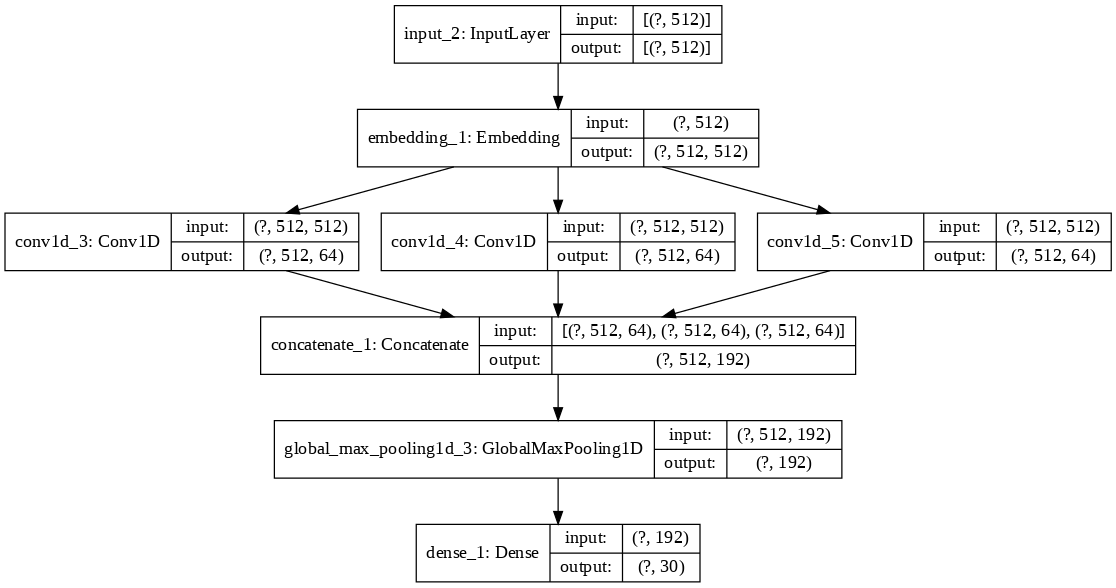

In [40]:
import keras
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [41]:
#training model
history = model.fit(X_train_padded, 
                    Y_train, 
                    validation_data=(X_test_padded, Y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True, 
                    use_multiprocessing=True)

Epoch 1/5
183/183 [==============================] - 40s 219ms/step - loss: 1.1704 - accuracy: 0.7199 - val_loss: 0.4290 - val_accuracy: 0.8888
Epoch 2/5
183/183 [==============================] - 39s 216ms/step - loss: 0.2824 - accuracy: 0.9310 - val_loss: 0.3075 - val_accuracy: 0.9157
Epoch 3/5
183/183 [==============================] - 40s 217ms/step - loss: 0.1207 - accuracy: 0.9748 - val_loss: 0.2815 - val_accuracy: 0.9241
Epoch 4/5
183/183 [==============================] - 40s 216ms/step - loss: 0.0528 - accuracy: 0.9922 - val_loss: 0.2683 - val_accuracy: 0.9274
Epoch 5/5
183/183 [==============================] - 39s 216ms/step - loss: 0.0320 - accuracy: 0.9958 - val_loss: 0.2661 - val_accuracy: 0.9292


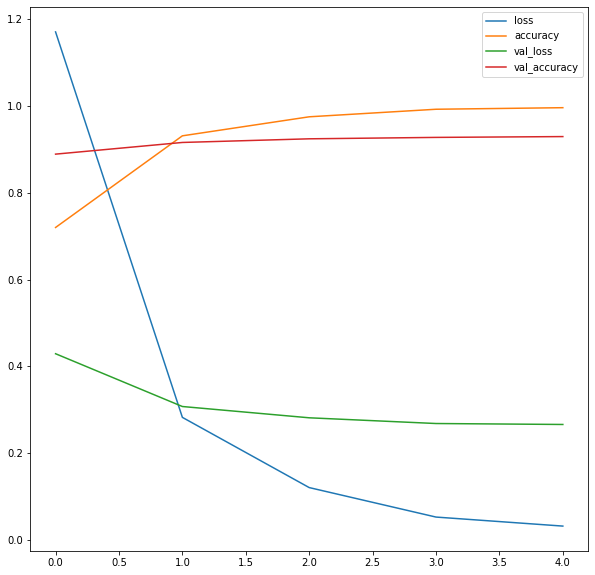

In [42]:
#plotting classification metrics on training and testing sets
pd.DataFrame(history.history).plot(figsize=(10, 10))

**SAVING MODEL**

In [44]:
#extacting model architecture in JSON format
json_model = model.to_json()

In [45]:
#saving model architecture into JSON file
with open("./drive/My Drive/model_architecture.json", 'w') as json_file:
  json_file.write(json_model)

In [46]:
#saving model weights
model.save_weights('./drive/My Drive/model_weights.h5')

**MODEL EVALUTION**

In [47]:
#predicting test set
Y_pred = model.predict(X_test_padded)

In [48]:
#getting top prediction for each observation
Y_pred2 = [np.argmax(x) for x in Y_pred]
Y_test2 = [np.argmax(x) for x in Y_test]
labels = list(encoder.classes_)

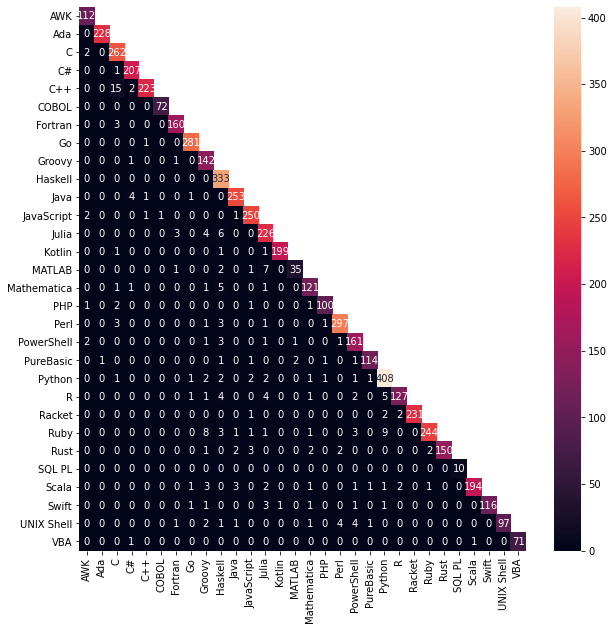

In [49]:
#plotting confusion matrix
plt.figure(figsize=(10, 10))
cm = confusion_matrix(Y_test2, Y_pred2)
mask = np.tri(cm.shape[0], k=-1)
mask = np.transpose(mask)
sns.heatmap(cm, annot=True, mask = mask, fmt='g', xticklabels=labels, yticklabels=labels)

In [50]:
#print classification report
print(classification_report(Y_test2, Y_pred2, target_names=labels))

              precision    recall  f1-score   support

         AWK       0.94      0.95      0.95       118
         Ada       1.00      0.97      0.98       234
           C       0.91      0.93      0.92       283
          C#       0.95      0.92      0.93       226
         C++       0.98      0.91      0.94       245
       COBOL       0.99      0.92      0.95        78
     Fortran       0.95      0.92      0.94       174
          Go       0.98      0.97      0.97       291
      Groovy       0.82      0.92      0.87       155
     Haskell       0.90      0.96      0.93       346
        Java       0.90      0.95      0.93       266
  JavaScript       0.92      0.95      0.93       264
       Julia       0.86      0.87      0.87       259
      Kotlin       0.99      0.96      0.98       207
      MATLAB       0.81      0.71      0.76        49
 Mathematica       0.88      0.90      0.89       134
         PHP       0.97      0.89      0.93       112
        Perl       0.93    